In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import ListedColormap


## Carga de datos

In [2]:
df_nasa = pd.read_csv("../../data/processed/nasa/nasa_processed_pc.csv")
df_nasa.head(1)

,coord_hash,t2m_mean,t2m_p95,t2m_p99,t2m_range,rh2m_mean,rh2m_p95,rh2m_p99,rad_mean,rad_p95,...,ws_days_gt_4,ws_days_gt_6,evland_mean,evland_p95,evland_p99,PC2_clima,PC3_clima,PC4_clima,PC5_clima,PC6_clima
0,0185cdf9e600,13.418689,14.91,15.63,6.03,87.438344,92.4,93.7196,16.388739,22.172,...,0,0,3.223436,4.51,4.9248,1.896154,-0.167227,-1.227641,0.361921,0.159969


In [3]:
df_usgs = pd.read_csv("../../data/processed/usgs/usgs_seismic_with_pca.csv")
df_usgs.head(1)

,row_id,n_sismos_M4,n_sismos_M5,mag_max,mag_mean,depth_mean,pct_superficiales,years_since_last_M5,PC1_sismo,PC2_sismo,PC3_sismo
0,0,24,24,5.6,4.629167,103.410167,0.125,0.164384,0.874367,-0.198804,0.702304


In [4]:
df_insqui = pd.read_csv("../../data/raw/nasa/coord_index.csv")
df_insqui.head(1)

,row_id,tipo_actividad,latitud,longitud,lat_r,lon_r,coord_hash
0,0,Administrativa,3.41,-76.53,3.41,-76.53,75246e90e485


In [5]:
df_final = df_insqui[[
    "row_id",
    "coord_hash",
    "latitud",
    "longitud",
    "tipo_actividad"
]].copy()


In [6]:
df_final = df_final.merge(
    df_nasa[["coord_hash", 
             "PC2_clima",
             "PC3_clima",
             "PC4_clima",
             "PC5_clima",
             "PC6_clima"
             ]],
    on="coord_hash",
    how="left"
)


In [7]:
df_final = df_final.merge(
    df_usgs[[
        "row_id",
        "PC1_sismo",
        "PC2_sismo",
        "PC3_sismo"
    ]].rename(columns={
        "PC1_sismo": "sismo_PC1",
        "PC2_sismo": "sismo_PC2",
        "PC3_sismo": "sismo_PC3"
    }),
    on="row_id",
    how="left"
)
df_final.describe()

,row_id,latitud,longitud,PC2_clima,PC3_clima,PC4_clima,PC5_clima,PC6_clima,sismo_PC1,sismo_PC2,sismo_PC3
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,3.900000e+02,3.900000e+02,3.900000e+02
mean,194.500000,5.855051,-75.180667,0.011431,0.124202,0.021123,0.046265,-0.149154,-6.376666e-17,9.109522e-18,2.049643e-17
std,112.727548,2.292545,1.150940,2.982230,2.351415,1.757079,1.155602,0.948906,1.693444e+00,1.441042e+00,1.008253e+00
min,0.000000,1.210000,-81.700000,-8.494893,-5.728505,-3.788559,-4.027142,-4.170502,-4.020492e+00,-6.369147e+00,-2.191644e+00
25%,97.250000,4.590000,-75.650000,-0.377106,-0.167315,-1.056730,-0.613303,-0.644779,-5.128015e-01,-1.988042e-01,-5.989731e-01
50%,194.500000,5.020000,-75.440000,0.660720,0.407772,-0.450599,-0.224116,-0.032470,-2.296466e-01,3.815531e-01,-3.973037e-01
75%,291.750000,6.317500,-74.200000,2.095626,1.622016,1.612770,1.354300,0.138993,7.183089e-01,7.274448e-01,6.596161e-01
max,389.000000,12.580000,-72.390000,4.229971,8.020950,4.233756,2.935952,4.811768,8.055812e+00,2.098046e+00,5.357419e+00


## Modelo One-hot encoding

In [8]:
# Asignación de variables de entrada
X_sismo = df_final[[
    "PC2_clima",
    "PC3_clima",
    "PC4_clima",
    "PC5_clima",
    "PC6_clima",
    "sismo_PC1",
    "sismo_PC2",
    "sismo_PC3"
]]

In [9]:
# Escalamiento de variables

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sismo)

In [10]:
# Selección del número óptimo de clusters con silhouette score

sil = {}

for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    sil[k] = silhouette_score(X_scaled, labels)

sil

{2: 0.4350595796509488,
 3: 0.34867016517295524,
 4: 0.45399366654432616,
 5: 0.49525517389378343,
 6: 0.5434211518642464}

2: 0.4350595796509488, -> RIESGO: bajo, alto

3: 0.34867016517295524, -> Valor vajo, RIESGO: bajo, medio, alto

4: 0.45399366654432616, -> RIESGO: bajo, medio, alto, muy alto

5: 0.49525517389378343, -> valor alto, no facil explicable

6: 0.5434211518642464, -> más alto pero demasiado ruido en la categorización

## Modelo de clustering

In [13]:
# Aplicación de KMeans con k=5
# Riesgo bajo, medio y alto
# Modelo entendible y explicable

k = 5  

kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
df_final_5 = df_final.copy()
df_final_5["nivel_riesgo"] = kmeans.fit_predict(X_scaled)


In [14]:
df_final_5.groupby("nivel_riesgo")[[
    "sismo_PC1",
    "sismo_PC2",
    "sismo_PC3"
]].mean()


,sismo_PC1,sismo_PC2,sismo_PC3
nivel_riesgo,,,
0,-0.236831,0.434673,-0.314624
1,-0.215120,0.977439,-0.506900
2,0.876484,-0.164634,0.577784
3,-1.813044,-1.943378,1.114811
4,7.738226,-3.093704,-1.135299


In [15]:
df_final_5.groupby("nivel_riesgo")[[
    "PC2_clima", "PC3_clima",
    "PC4_clima", "PC5_clima",
    "PC6_clima"
]].mean()


,PC2_clima,PC3_clima,PC4_clima,PC5_clima,PC6_clima
nivel_riesgo,,,,,
0,1.965959,1.319758,-0.438320,0.829255,-0.119945
1,-0.466800,0.235082,2.337841,-1.156289,-1.099777
2,0.443215,-3.851150,-0.694571,-0.340557,0.239849
3,-5.522618,1.984020,-1.692133,-0.133139,0.322079
4,-1.276501,0.991828,2.899067,1.176393,1.483832


In [16]:
df_final_5.dtypes

row_id              int64
coord_hash            str
latitud           float64
longitud          float64
tipo_actividad        str
PC2_clima         float64
PC3_clima         float64
PC4_clima         float64
PC5_clima         float64
PC6_clima         float64
sismo_PC1         float64
sismo_PC2         float64
sismo_PC3         float64
nivel_riesgo        int32
dtype: object

In [23]:
map_amenaza = {
    0: "Amenaza por clima variable",
    1: "Amenaza por clima húmedo",
    2: "Amenaza por sismos",
    3: "Amenaza por clima extremo",
    4: "Amenaza alta combinada"
}

df_final_5["nivel_riesgo"] = pd.to_numeric(df_final_5["nivel_riesgo"], errors="coerce").astype("Int64")
df_final_5["nivel_riesgo_cat"] = df_final_5["nivel_riesgo"].map(map_amenaza)
df_final_5.head(1)

,row_id,coord_hash,latitud,longitud,tipo_actividad,PC2_clima,PC3_clima,PC4_clima,PC5_clima,PC6_clima,sismo_PC1,sismo_PC2,sismo_PC3,nivel_riesgo,nivel_riesgo_cat
0,0,75246e90e485,3.41,-76.53,Administrativa,0.66072,-4.202741,-1.013807,-0.462771,0.060718,0.874367,-0.198804,0.702304,2,Amenaza por sismos


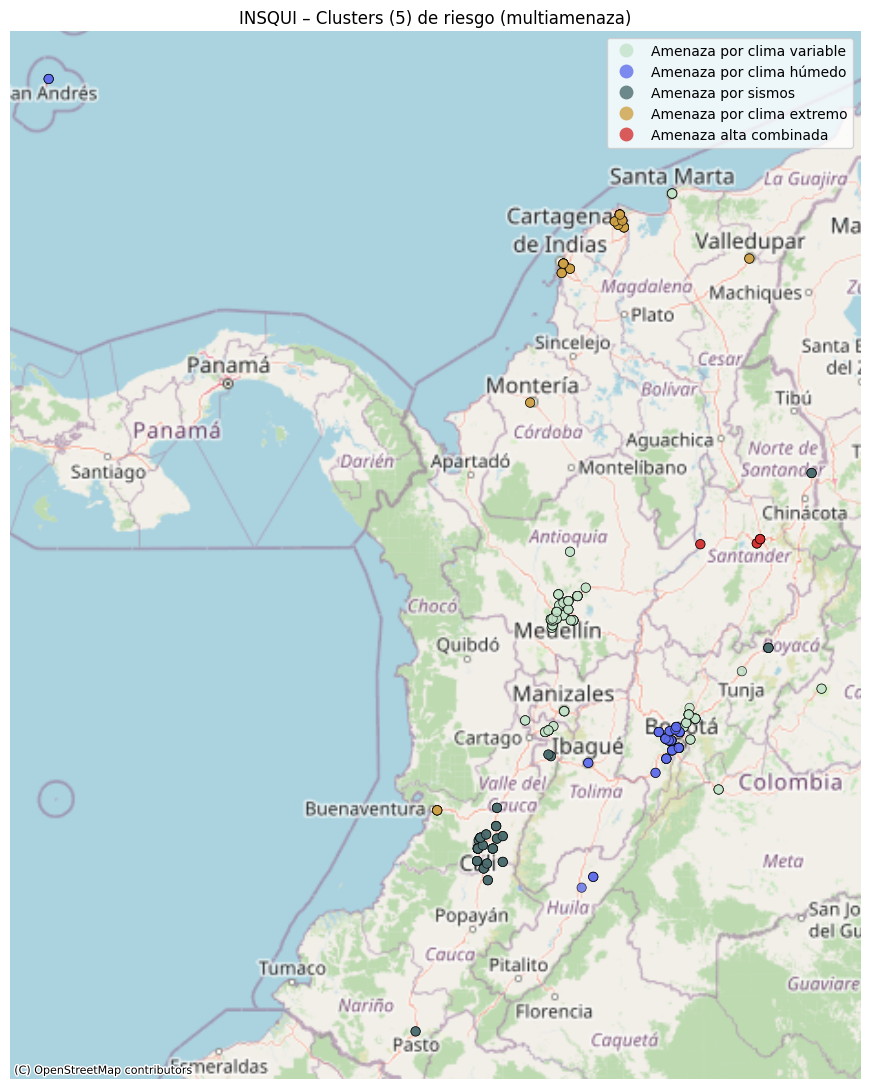

In [28]:
# Colores por nivel
orden = ["Amenaza por clima variable", 
         "Amenaza por clima húmedo", 
         "Amenaza por sismos", 
         "Amenaza por clima extremo",
         "Amenaza alta combinada"
         ]

colors_list = [
    "#C3E3C9",
    "#606EEC",
    "#4D6D6F",
    "#CEA147",
    "#D33333D6" 
]

cmap_manual = ListedColormap(colors_list)

# Asegurar orden categórico (clave para leyenda correcta)
df_final_5["nivel_riesgo_cat"] = pd.Categorical(
    df_final_5["nivel_riesgo_cat"],
    categories=orden,
    ordered=True
)

# GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_final_5.copy(),
    geometry=gpd.points_from_xy(
        df_final_5["longitud"],
        df_final_5["latitud"]
    ),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Visualización
fig, ax = plt.subplots(figsize=(15, 11))

xmin, ymin, xmax, ymax = gdf.total_bounds
padx = 0.05 * (xmax - xmin) if xmax > xmin else 1000
pady = 0.05 * (ymax - ymin) if ymax > ymin else 1000
ax.set_xlim(xmin - padx, xmax + padx)
ax.set_ylim(ymin - pady, ymax + pady)

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    zoom="auto",
    zorder=0
)

gdf.plot(
    ax=ax,
    column="nivel_riesgo_cat",
    categorical=True,
    cmap=cmap_manual,
    legend=True,
    markersize=45,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.5,
    zorder=2
)

ax.set_axis_off()
ax.set_title("INSQUI – Clusters (5) de riesgo (multiamenaza)")
plt.tight_layout()
plt.show()

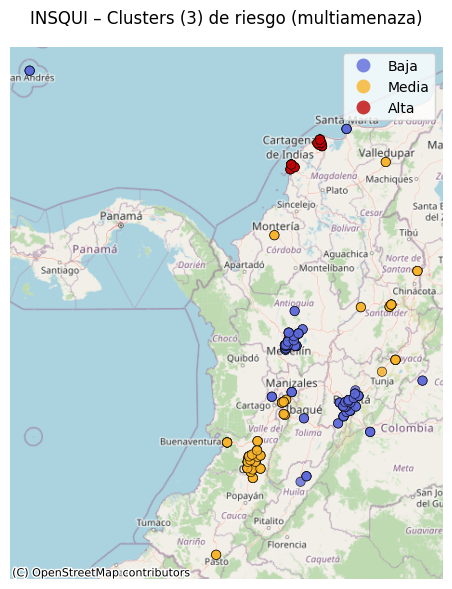

In [27]:
# Repetición con k=3 y colores manuales
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)

df_final_3 = df_final.copy()
df_final_3["nivel_riesgo"] = kmeans.fit_predict(X_scaled)

# Análisis de clusters
map_amenaza = {
    0: "Baja",
    1: "Media",
    2: "Alta",
}

df_final_3["nivel_riesgo"] = pd.to_numeric(
    df_final_3["nivel_riesgo"], errors="coerce"
).astype("Int64")

df_final_3["nivel_riesgo_cat"] = df_final_3["nivel_riesgo"].map(map_amenaza)
# Colores por nivel
orden = ["Baja", "Media", "Alta"]

colors_list = [
    "#5E6ADA",
    "#F9B429",
    "#C10707D7" 
]

cmap_manual = ListedColormap(colors_list)

# Asegurar orden categórico (clave para leyenda correcta)
df_final_3["nivel_riesgo_cat"] = pd.Categorical(
    df_final_3["nivel_riesgo_cat"],
    categories=orden,
    ordered=True
)

# GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_final_3.copy(),
    geometry=gpd.points_from_xy(
        df_final_3["longitud"],
        df_final_3["latitud"]
    ),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))

xmin, ymin, xmax, ymax = gdf.total_bounds
padx = 0.05 * (xmax - xmin) if xmax > xmin else 1000
pady = 0.05 * (ymax - ymin) if ymax > ymin else 1000
ax.set_xlim(xmin - padx, xmax + padx)
ax.set_ylim(ymin - pady, ymax + pady)

ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    zoom="auto",
    zorder=0
)

gdf.plot(
    ax=ax,
    column="nivel_riesgo_cat",
    categorical=True,
    cmap=cmap_manual,
    legend=True,
    markersize=45,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.5,
    zorder=2
)

ax.set_axis_off()
ax.set_title("INSQUI – Clusters (3) de riesgo (multiamenaza)")
plt.tight_layout()
plt.show()


In [29]:
df_final_5.to_csv("../../data/processed/insqui/insqui_threat_levels_k5.csv", index=False)